In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Define coupled derivitives to integrate

In [2]:
def dydx(x,y):
    #set derivatives
    #the equation d^2y / dx^2 = -y
    #dy/dx = z
    #dz/dx = -y
    #set y[0] = 0 and y[1] = z
    
    #declare an array
    y_derivs = np.zeros(2)
    
    #set dydx = z
    y_derivs[0] = y[1]
    
    #set dzdx = -y
    y_derivs[1] = -1*y[0]
    
    #return array
    return y_derivs

## Define the 4th order RK method

In [3]:
def rk4_mv_core(dydx,xi,yi,nv,h):
    #declare k? arrays
    k1 = np.zeros(nv)
    k2 = np.zeros(nv)
    k3 = np.zeros(nv)
    k4 = np.zeros(nv)
    
    #define x at 1/2 step
    x_ipoh = xi + 0.5*h
    
    #define x at 1 step
    x_ipo = xi + h
    
    #declare
    y_temp = np.zeros(nv)
    
    #get k1 values
    y_derivs = dydx(xi,yi)
    k1[:] = h*y_derivs[:]
    
    #get k2 values
    y_temp[:] = yi[:] + 0.5*k1[:]
    y_derivs[:] = dydx(x_ipoh, y_temp)
    k2[:] = h*y_derivs[:]
    
    #get k3 values
    y_temp[:] = yi[:] + 0.5*k2[:]
    y_derivs[:] = dydx(x_ipoh, y_temp)
    k3[:] = h*y_derivs[:]
    
    #get k4 values
    y_temp[:] = yi[:] + k3[:]
    y_derivs[:] = dydx(x_ipo, y_temp)
    k4[:] = h*y_derivs[:]
    
    #advance y by a step h
    yipo = yi + (k1 + 2*k2 +2*k3 + k4)/6
    
    return yipo

## Define adaptive step size driver

In [4]:
def rk4_mv_ad(dydx,x_i,y_i,nv,h,tol):
    #define safety scale
    SAFETY = 0.9
    H_NEW_FAC = 2.0
    
    #set maximum number of iterations and iteration variable
    imax = 1000
    i = 0
    
    #create an error
    Delta = np.full(nv,2*tol)
    
    #remember the step
    h_step = h
    
    #adjust step if necessary
    while(Delta.max()/tol > 1.0):
        #estimate the error by taking one step of size h and
        #compare with twp steps of size h/2
        
        #one big step
        y_2 = rk4_mv_core(dydx,x_i,y_i,nv,h_step)
        #two small steps
        y_1 = rk4_mv_core(dydx,x_i,y_i,nv,0.5*h_step)
        y_11 = rk4_mv_core(dydx,x_i+0.5*h_step,y_1,nv,0.5*h_step)
        
        #compute error estamite
        Delta = np.fabs(y_2 - y_11)
        
        #if the error is too large, take a smaller step
        if(Delta.max()/tol>1.0):
            
            #our error is too big, decrease the step
            h_step *= SAFETY * (Delta.max()/tol)**(-0.25)
        
        
        #check iterations
        if (i >= imax):
            
            print("Too many iterations in rk4_mv_ad()")
            raise StopIteration("Ending after i = ",i)
            
        #iterate
        i += 1
        
        
        
        #out of loop here
        
        #next time try a bigger step
        h_new = np.fmin(h_step * (Delta.max()/tol)**(-0.9), h_step*H_NEW_FAC)
        
        #return the answer, a new step, and the step we took
        return y_2, h_new, h_step

## Define wrapper for RK4

In [5]:
def rk4_mv(dydx,a,b,y_a,tol):
    #dfdx is the derivative wrt x
    #a is lower bound
    #b is lower bound
    #y_a is the boundry conditions at a
    #tol is the toloerance for integrating y at a
    
    #define starting step
    xi = a
    yi = y_a.copy()
    
    #an initial step size 
    h = 1.0e-4 * (b-a)
    
    #set max iterations and iteration variable
    imax = 10000
    i = 0
    
    #set number of coupled odes to the size of y_a
    nv = len(y_a)
    
    #set the inital conitions
    x = np.full(1,a)
    y = np.full((1,nv),y_a)
    
    #set flag
    flag = 1
    
    #loop until we reach the right side
    while (flag):
        
        #calculate y_i+1
        yi_new, h_new, h_step = rk4_mv_ad(dydx,xi,yi,nv,h,tol)
        
        #update step
        h = h_new
        
        #prevent overshoot
        if (xi + h_step) > b:
            
            #take smaller step
            h = b - xi
            
            #recalculate y_i+1
            yi_new, h_new, h_step = rk4_mv_ad(dydx,xi,yi,nv,h,tol)
        
            #break
            flag = 0
            
        #update values
        xi += h_step
        yi[:] = yi_new[:]
        
        #add the step to the arrays
        x = np.append(x,xi)
        y_new = np.zeros((len(x),nv))
        y_new[0:len(x)-1,:] = y
        y_new[-1,:] = yi[:]
        del y
        y = y_new
        
        #prevent too mant itereations
        if (i > imax):
            print("Maximum iterations reached")
            raise StopIteration("Iteration number = ",i)
                      
        #iterate
        i += 1
        
        #output info
        s = "i = %3d\tx = %9.8f\th = %9.8f\tb = %9.8f" % (i,xi,h_step,b)
        print(s)
        
        #break if new xi is == b
        if (xi == b):
            flag = 0
    #return answer
    return x,y

## Perform Integration

In [6]:
a = 0.0
b = 2.0 * np.pi

y_0 = np.zeros(2)
y_0[0] = 0.0
y_0[1] = 1.0
nv = 2

tolerance = 1.0e-6

#perform integration
x,y = rk4_mv(dydx,a,b,y_0,tolerance)

i =   1	x = 0.00062832	h = 0.00062832	b = 6.28318531
i =   2	x = 0.00188496	h = 0.00125664	b = 6.28318531
i =   3	x = 0.00439823	h = 0.00251327	b = 6.28318531
i =   4	x = 0.00942478	h = 0.00502655	b = 6.28318531
i =   5	x = 0.01947787	h = 0.01005310	b = 6.28318531
i =   6	x = 0.03958407	h = 0.02010619	b = 6.28318531
i =   7	x = 0.07979645	h = 0.04021239	b = 6.28318531
i =   8	x = 0.16022123	h = 0.08042477	b = 6.28318531
i =   9	x = 0.32107077	h = 0.16084954	b = 6.28318531
i =  10	x = 0.46816761	h = 0.14709684	b = 6.28318531
i =  11	x = 0.55240352	h = 0.08423590	b = 6.28318531
i =  12	x = 0.72087532	h = 0.16847181	b = 6.28318531
i =  13	x = 0.87828819	h = 0.15741287	b = 6.28318531
i =  14	x = 0.99010865	h = 0.11182046	b = 6.28318531
i =  15	x = 1.13339227	h = 0.14328362	b = 6.28318531
i =  16	x = 1.17554701	h = 0.04215475	b = 6.28318531
i =  17	x = 1.25985651	h = 0.08430949	b = 6.28318531
i =  18	x = 1.40955970	h = 0.14970319	b = 6.28318531
i =  19	x = 1.55209634	h = 0.14253664	b = 6.28

## Plot result

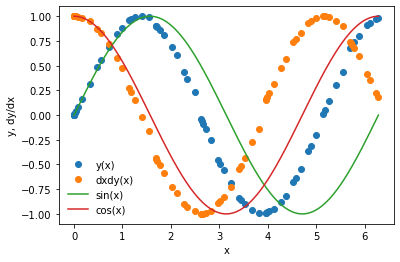

In [8]:
plt.plot(x,y[:,0],"o",label="y(x)")
plt.plot(x,y[:,1],"o",label="dxdy(x)")
xx = np.linspace(0,2.0*np.pi,1000)
plt.plot(xx,np.sin(xx),label = "sin(x)")
plt.plot(xx,np.cos(xx),label = "cos(x)")
plt.xlabel("x")
plt.ylabel("y, dy/dx")
plt.legend(frameon = False)

## Plot the Error

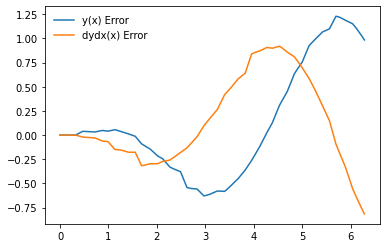

In [9]:
sine = np.sin(x)
cosine = np.cos(x)

y_error = (y[:,0]-sine)
dydx_error = (y[:,1]-cosine)

plt.plot(x, y_error, label = "y(x) Error")
plt.plot(x, dydx_error, label = "dydx(x) Error")
plt.legend(frameon = False)